### 0. Import and global variables

In [1]:
from wavescapes import *
import pylab
import scipy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Arc
import math


test_midi_folder = 'midiFiles/'
test_xml_folder = 'xmlFiles/'
ligeti_xml = test_xml_folder+'Ligetivol1no2.musicxml'
webern_xml = test_xml_folder + 'WebernNo1.mxl'
bach_prelude_midi = test_midi_folder + '210606-Prelude_No._1_BWV_846_in_C_Major.mid'
faust_symphony_midi = test_midi_folder+'Faust_Symphony_mov1.mid'
ave_maria_midi = test_midi_folder+'AveMaria_desPrezmid.mid'
giant_steps_midi = test_midi_folder+'giant_steps_first_chorus.mid'
chopin_midi = test_midi_folder+'chopin-prelude-op28-2.mid'
scriabin_midi = test_midi_folder+'Op74_No2_Pure.mid'

filenames_and_resolution = [(faust_symphony_midi, 1), (ave_maria_midi, 8), (bach_prelude_midi, 1),\
                            (chopin_midi, 1), (scriabin_midi, 1), (giant_steps_midi, 1),\
                            (ligeti_xml, 1), (webern_xml, .25)]

/usr/local/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


## 1. Introduction 

### 2. Keyscape and keyscape legend

In [ ]:
twelve_tones_major_key_names = ['C','D$\\flat$','D','E$\\flat$','E','F','G$\\flat$','G','A$\\flat$','A','B$\\flat$','B']
twelve_tones_minor_key_names = ['c','c$\sharp$','d','e$\\flat$','e','f','f$\sharp$','g','g$\sharp$','a','b$\\flat$','b']

krumhansl_maj = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
krumhansl_min = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

krumhansl_minor_keys = [np.roll(krumhansl_min, i) for i in range(len(krumhansl_min))]
krumhansl_major_keys = [np.roll(krumhansl_maj, i) for i in range(len(krumhansl_maj))]

def nth_coeff_phase(input_vec, n_coeff):
    assert(n_coeff <= len(input_vec))
    if not np.any(input_vec):
        return white_value
    dft_nth_coeff = np.fft.fft(input_vec)[n_coeff]
    return np.angle(dft_nth_coeff)

def rgba_to_rgb(to_convert, background):
    if len(to_convert) == 3:
        return to_convert #no point converting something that is already in RGB
    if len(to_convert) != 4:
        raise Exception('Incorrect format for the value to be converted, should have length of 4')
    if len(background) != 3:
        raise Exception('Incorrect format for the value background, should have length of 3 (no alpha channel for this one)')
    alpha = float(to_convert[3])/255.0
    return [int((1 - alpha) * background[i] + alpha * to_convert[i]) for i in range(len(background))]

stand = lambda v: int(v*0xff)

def circular_hue(angle, magnitude=1., opacity_mapping=True):
    
    #np.angle returns value in the range of [-pi : pi], where the circular hue is defined for 
    #values in range [0 : 2pi]. Rather than shifting by a pi, the solution is for the negative
    #part to be mapped to the [pi: 2pi] range which can be achieved by a modulo operation.
    def two_pi_modulo(value):
        return np.mod(value, 2*math.pi)
    
    def step_function_quarter_pi_activation(lo_bound, hi_bound, value):
        #in the increasing path branch
        if value >= lo_bound and value <= lo_bound + math.pi/3:
            return ((value-lo_bound)/(math.pi/3))
        #in the decreasing path branch
        elif value >= hi_bound and value <= hi_bound + math.pi/3:
            return 1-((value-hi_bound)/(math.pi/3))
        else:
            #the case of red 
            if lo_bound > hi_bound:
                return 0 if value > hi_bound and value < lo_bound else 1
            else:
                return 1 if value > lo_bound and value < hi_bound else 0
            
    #Need to shift the value with one pi as the range of the angle given is between pi and minus pi
    #and the formulat I use goes from 0 to 2pi.
    angle = two_pi_modulo(angle)
    green = lambda a: step_function_quarter_pi_activation(0, math.pi, a)
    blue = lambda a: step_function_quarter_pi_activation(math.pi*2/3, math.pi*5/3, a)
    red = lambda a: step_function_quarter_pi_activation(math.pi*4/3, math.pi/3, a)
    value = None
    if opacity_mapping:
        value = (stand(red(angle)), stand(green(angle)), stand(blue(angle)), stand(magnitude))
        #defautl background for the opacity is white.
        value = rgba_to_rgb(value, background=(0xff,0xff,0xff))
    else:
        value = (stand(red(angle)), stand(green(angle)), stand(blue(angle)))
        value = rgb_to_saturated_rbg(value, magnitude)
    return value

def build_utm_from_one_row(res):
    '''
    given a NxN matrix whose first row is the only
    one that's filled with values, this function fills
    all the above row by summing for each row's element
    the two closest element from the row below. This
    method of summing builds an upper-triangle-matrix
    whose structure represent all hierarchical level.
    '''
    pcv_nmb = np.shape(res)[0]
    for i in range(1, pcv_nmb):
        for j in range(0, pcv_nmb-i):
            res[i][i+j] = res[0][i+j] + res[i-1][i+j-1]
    return res

def rgb_to_hex(rgb):
    if type(rgb) is str and rgb[0] == '#' and len(rgb) > 6:
        # we already have an hex value given let's just return it back.
        return rgb 
    elif len(rgb) == 3:
        return '#%02x%02x%02x' % (rgb[0],rgb[1],rgb[2])
    elif len(rgb) == 4:
        return '#%02x%02x%02x%02x' % (rgb[0],rgb[1],rgb[2], rgb[3])
    else:
        raise Exception('Cannot convert RGB tuple to hex value if the value given is neither in the RGB or the RGBA format.')




krumhansl_major_angle_dict = {k: nth_coeff_phase(v, 5) for k, v in zip(twelve_tones_major_key_names, krumhansl_major_keys)}
krumhansl_minor_angle_dict = {k: nth_coeff_phase(v, 5) for k, v in zip(twelve_tones_minor_key_names, krumhansl_minor_keys)}

krumhansl_major_color_dict = {k: circular_hue(v) for k,v in krumhansl_major_angle_dict.items()}
minor_colors = [circular_hue(v, magnitude=.5) for v in krumhansl_major_angle_dict.values()]
krumhansl_minor_color_dict = dict(zip(np.roll(list(krumhansl_minor_angle_dict.keys()), 3), minor_colors))


def scalar_product(input_vec, key_prof, shift_idx):
    # compute the scalar product between a pitch class (input_vec),
    # and a key profile starting at C (key_prof). The argument "shift_idx"
    # indicates at which pitch should the scalar product begin according to the 
    # key profile.
    acc = 0
    pitch_class_size = len(key_prof)
    for i in range(pitch_class_size):
        acc += input_vec[i]*key_prof[(i-shift_idx)%pitch_class_size]
    return acc


def ks_key_finding_algo(pcv, maj_prof, min_prof):
    pcv = scipy.stats.zscore(pcv)
    
    # Generate all rotations of major and minor profile given
    major = scipy.linalg.circulant(maj_prof)
    minor = scipy.linalg.circulant(min_prof)
    
    return major.T.dot(pcv), minor.T.dot(pcv)

def select_best_key_ks(input_vec, key_prof_maj, key_prof_min):
    key_idx = np.argmax(np.vstack(ks_key_finding_algo(input_vec, key_prof_maj, key_prof_min)))
    #np.argmax return only a singular index, regardless of the array shape, meaning that above 11, that
    #that means the key was identified in the second row, i.e. the minor key.
    return (key_idx % 12, key_idx < 12)   

def pitch_to_color_template_matching(pitch_class_vector, major_profile, minor_profile, major_colors, minor_colors):
    if not np.any(pitch_class_vector):
        #this means the vector only has 0 values.
        return [255,255,255]
    key, is_major = select_best_key_ks(pitch_class_vector, major_profile, minor_profile)
    pitch_to_rgb = None
    if is_major:
        pitch_to_rgb = major_colors.values() 
    else:
        m = list(minor_colors.values())
        #centering the minor color on C for consistency with the rest of the code. 
        pitch_to_rgb = m[3:]+m[:3]
        
    indexes = [i for i in range(len(pitch_to_rgb))]
    index_to_rgb = dict(zip(indexes, pitch_to_rgb))
    return index_to_rgb[key]

krumhansl_color_mapping = lambda pcv: pitch_to_color_template_matching(pcv, krumhansl_maj, krumhansl_min, krumhansl_major_color_dict, krumhansl_minor_color_dict)

def pcv_array_to_keyscape(pcv_array, color_mapping):
    pcv_nmb = len(pcv_array)
    
    res_vector = np.full((pcv_nmb, pcv_nmb, 12), 0.0, np.float64)
    res_vector[0] = pcv_array
    pcv_mat = build_utm_from_one_row(res_vector)
    
    res_mat = np.full((pcv_nmb, pcv_nmb, 3), (0xff), np.uint8)
    for i in range(0, pcv_nmb):
        for j in range(0, pcv_nmb):
            color = color_mapping(pcv_mat[i][j])
            res_mat[i][j] = color
    return res_mat

def order_by_fifth(input_vec):
    one_elem_type = type(input_vec[0])
    zero_elem = '' if one_elem_type is str else 0
    res = [zero_elem]*len(input_vec)
    for i in range(len(input_vec)):
        curr_elem = input_vec[i]
        res[(i*7)%12] = curr_elem
    #centering on C Major
    return res[6:]+res[:6]

def color_mapping_color_legend(major_label_color_dict, minor_label_color_dict, plot_width=20):
    keys_nbr = len(major_label_color_dict)
    marker_size = (2.*(plot_width+2))/(3*(keys_nbr+1))
    plot_height = 3*marker_size
    xs = np.arange(0,plot_width,1.5*marker_size)
    bottom_y = 0
    top_y = 1.5*marker_size
    ys = [top_y, bottom_y]
    fig, ax = plt.subplots(figsize=(plot_width-1.5,plot_height))
    
    
    major_label_color = np.array([[k,v] for k,v in major_label_color_dict.items()])
    minor_label_color = np.array([[k,v] for k,v in minor_label_color_dict.items()])
    colors_mat = np.array((order_by_fifth(major_label_color[:,1]),\
                           order_by_fifth(minor_label_color[:,1])))
    labels_mat = np.array((order_by_fifth(major_label_color[:,0]), \
                           order_by_fifth(minor_label_color[:,0])))
    
    for i in range(len(ys)):
        curr_colors = colors_mat[i]
        curr_labels = labels_mat[i]
        for j in range(len(xs)):
            curr_color = rgb_to_hex(curr_colors[j])
            rect = mpl.patches.Rectangle((xs[j],ys[i]),marker_size,marker_size,linewidth=1,facecolor=curr_color)
            #ha = horizontal alignment, va = vertical alignment
            plt.text(xs[j]+marker_size/2., ys[i]+marker_size/2., curr_labels[j], va='center', ha='center', fontsize=30)#, horizontalignment='center')
            ax.add_patch(rect)
    plt.axis('off')
    pylab.axis('scaled')


color_mapping_color_legend(krumhansl_major_color_dict, krumhansl_minor_color_dict)
plt.tight_layout()
plt.savefig('color_legend.png')

pcv_array = produce_pitch_class_matrix_from_filename(faust_symphony_midi)
color_mat = pcv_array_to_keyscape(pcv_array, krumhansl_color_mapping)
ws = Wavescape(color_mat, 500, drawing_primitive='rhombus')
ws.draw(tick_ratio = 4, start_offset=1)
plt.savefig('faust_ks_kr.png')

pcv_array = produce_pitch_class_matrix_from_filename(bach_prelude_midi)
color_mat = pcv_array_to_keyscape(pcv_array, krumhansl_color_mapping)
ws = Wavescape(color_mat, 500, drawing_primitive='rhombus')
ws.draw(tick_ratio = 4)
plt.savefig('bach_ks_kr.png')

## 2. Methodology

### 2.1 heatmap

In [ ]:
nth_coeff_magn = lambda z, n: np.abs(np.fft.fft(z)[n])
total_dict = {
    'Single tone (1)' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'Tritone (2)' : [1,0,0,0,0,0,1,0,0,0,0,0],
    'Major/minor triad (3)' : [1,0,0,1,0,0,0,1,0,0,0,0],
    'Augmented triad (3)':   [1,0,0,0,1,0,0,0,1,0,0,0],
    'M7 chord (4)' : [1,0,0,0,1,0,0,1,0,0,0,1],
    'm7 chord (4)' : [1,0,0,1,0,0,0,1,0,0,1,0],
    'dom/half-dim. chord (4)' :  [1,0,0,0,1,0,0,1,0,0,1,0],
    'Dim. chord (4)': [1,0,0,1,0,0,1,0,0,1,0,0],
    'Pentatonic scale (5)': [1,0,1,0,1,0,0,1,0,1,0,0],
    'Guido\'s hexachord (6)' :[1,0,1,0,1,1,0,1,0,1,0,0],
    'Whole-tone scale (6)' : [0,1,0,1,0,1,0,1,0,1,0,1],
    '6 chromatic tones (6)': [1,1,1,1,0,0,0,0,0,0,1,1],
    'Diatonic scale (7)': [1,0,1,0,1,1,0,1,0,1,0,1],
    #'Harmonic minor scale (7)': [1,0,1,0,1,1,0,0,1,1,0,1],
    '3 chromatic tritones (6)' : [1,1,0,0,0,1,1,1,0,0,0,1],
    'Hexatonic scale (6)': [1,1,0,0,1,1,0,0,1,1,0,0],
    'Octatonic scale (8)': [1,1,0,1,1,0,1,1,0,1,1,0],
    'All tones (12)': [1,1,1,1,1,1,1,1,1,1,1,1]
}

coeffs_1_to_6 = {str(i):i for i in range(1,7)}


def heatmap_plotting(labels_in_vec_dict, coeffs_dict, normalization=True, figsize = (16, 24), epsilon=.0001):
    labelsize= 20
    plt.figure(figsize=figsize)
    mpl.rc('xtick', labelsize=labelsize) 
    mpl.rc('ytick', labelsize=labelsize)
    
    labels = list(labels_in_vec_dict.keys())
    vectors = list(labels_in_vec_dict.values())
    coeffs = list(coeffs_dict.values())
    x_len = len(labels)
    y_len = len(coeffs)
    matrice = np.full((x_len, y_len), 0.0, np.float32)
    for i in range(x_len):
        for j in range(y_len):
            vec = vectors[i]
            coeff = coeffs[j]
            norm_magn = nth_coeff_magn(vec, coeff)/(sum(vec) if normalization else 1.0)
            norm_magn = norm_magn #if norm_magn > epsilon else 0.
            matrice[i][j] = norm_magn

    cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
    ax = sns.heatmap(matrice, yticklabels=labels, xticklabels=list(coeffs_dict.keys()), square=True, cmap=cmap, annot=True, annot_kws={"size": labelsize})
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xlabel('k', fontsize=labelsize)
    return ax

heatmap_plotting(total_dict, coeffs_1_to_6)
plt.tight_layout()

### Polar representation of complex number

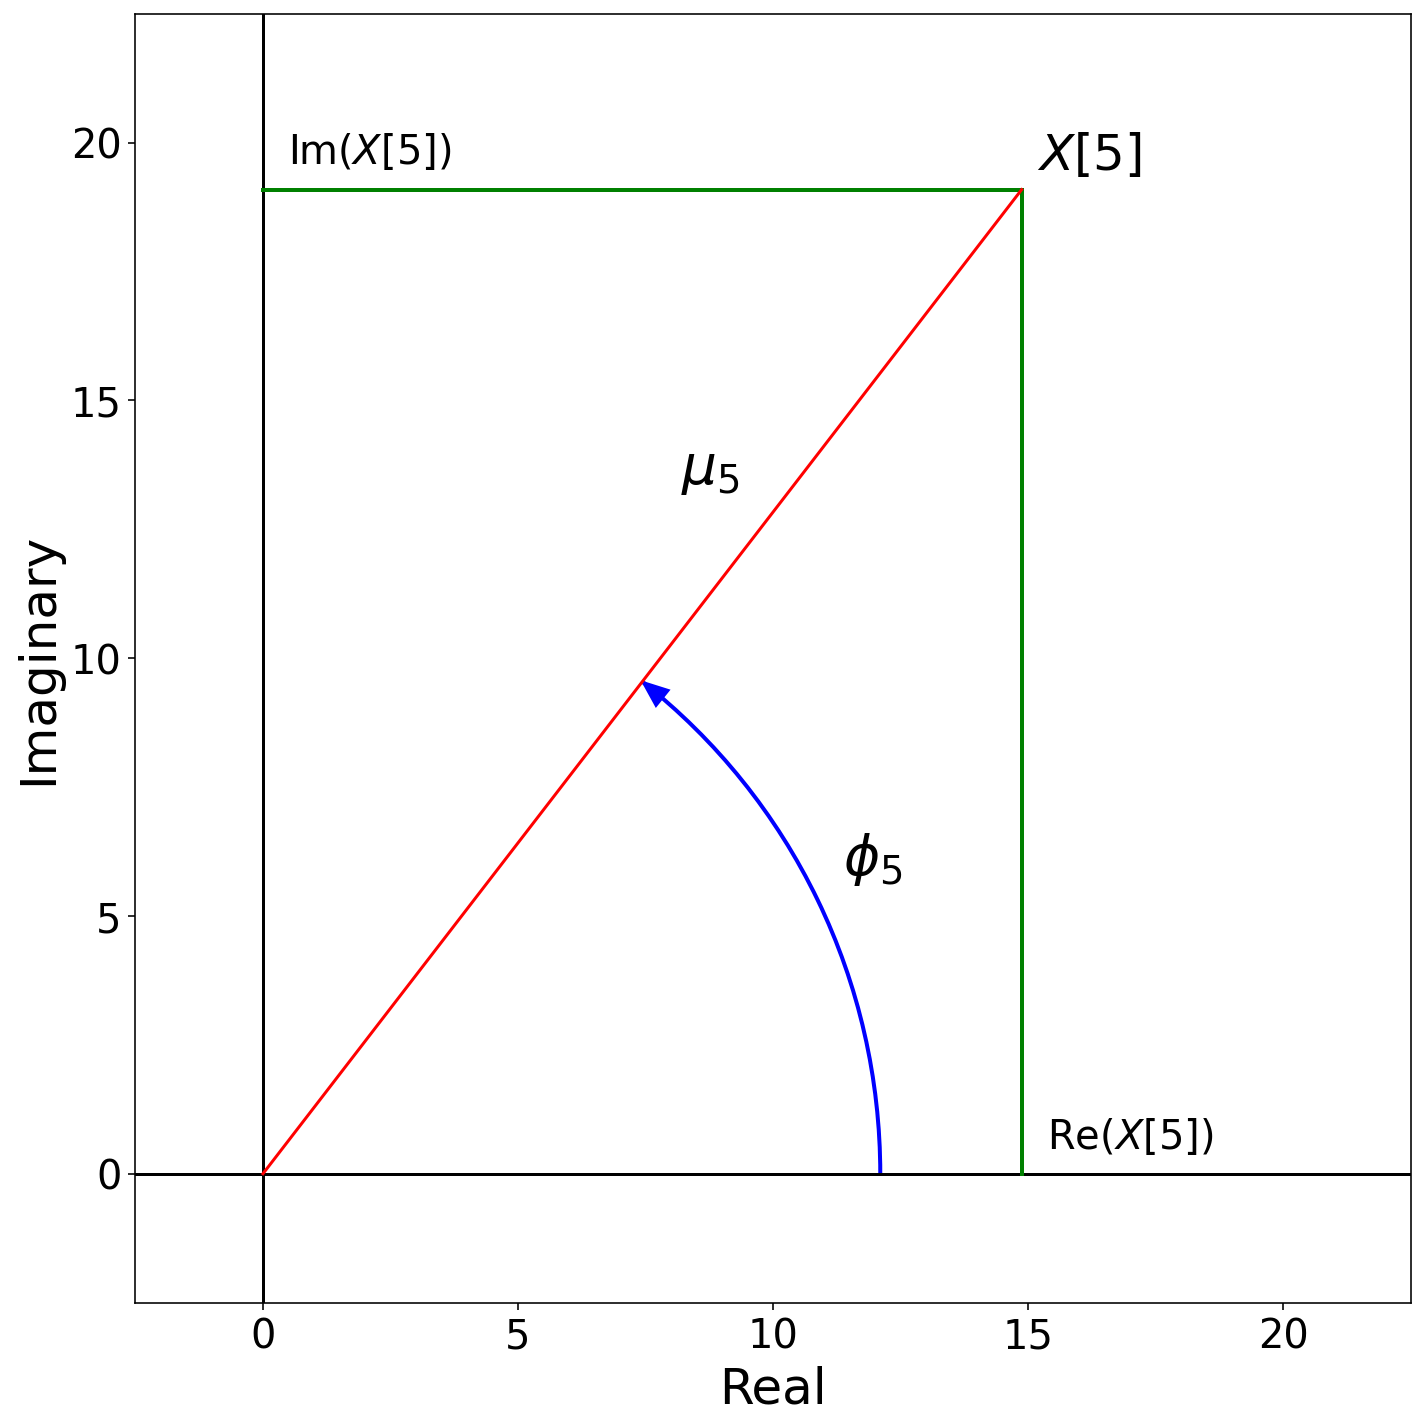

In [10]:
def argand(a, show_magn=True):
    lw = 2
    font_size = 20
    bigger_font_size = font_size*1.25
    fig, ax = plt.subplots(figsize=(font_size/2,font_size/2))
    mpl.rc('xtick', labelsize=font_size)
    mpl.rc('ytick', labelsize=font_size)
    plt.rc('axes', labelsize=font_size)
    
    x = a.real
    y = a.imag
    arc_w = np.abs(a)[0]
    angle = (np.angle(a))[0] * (180/math.pi)

    ax.axhline(0, color='black', linestyle='-')
    ax.axvline(0, color='black', linestyle='-')
    plt.grid(True)
    
     #Real line
    plt.plot((x, x), (0, y), 'k', color='green', linewidth=lw)
    ax.text(x+.5, .5, '$\operatorname{Re}(X[5])$', fontdict={'size':font_size})
    
    
    #Imaginary line
    plt.plot((0, x), (y, y), 'k', color='green', linewidth=lw)
    ax.text(.5, y+.5, '$\operatorname{Im}(X[5])$', fontdict={'size':font_size})
    if show_magn:
        
        label_x = (arc_w/2)*np.cos(np.angle(a)[0]/2)+.5
        label_y = (arc_w/2)*np.sin(np.angle(a)[0]/2)+.5
        ax.text(label_x, label_y, '$\phi_5$', fontdict={'size':bigger_font_size*1.1})
        
        hatf_x = (arc_w/2)*np.cos(np.angle(a)[0]+0.125) + 2
        hatf_y = (arc_w/2)*np.sin(np.angle(a)[0]+0.125)+ 3
        ax.text(hatf_x, hatf_y, '$\mu_5$', fontdict={'size':bigger_font_size*1.1})
        
        arrow_x = (arc_w/2)*np.cos(np.angle(a)[0]-0.042)
        arrow_y = (arc_w/2)*np.sin(np.angle(a)[0]-0.042)
        
        dxdy = np.array([x[0]/2, y[0]/2]) - np.array([arrow_x, arrow_y])
        arc_arrow_dx = dxdy[0]
        arc_arrow_dy = dxdy[1]
        ax.arrow(
            arrow_x,
            arrow_y,
            arc_arrow_dx*0.00001,
            arc_arrow_dy*0.00001,
            head_width=0.4,
            head_length=0.5,
            color='blue')
        arc = Arc((0,0), arc_w, arc_w, angle = 0, theta1=0, theta2=angle, color='blue', linewidth=lw)
        ax.add_patch(arc)
        
        plt.plot([0,a.real],[0,a.imag],'r-',label='python', markersize=font_size*0.8)
    else:
        plt.scatter(a.real,a.imag, s=[font_size*10])
    
    
    coeff_x = (arc_w+0.5)*np.cos(np.angle(a)[0])
    coeff_y = (arc_w+0.5)*np.sin(np.angle(a)[0])
    ax.text(coeff_x, coeff_y, '$X[5]$', fontdict={'size':bigger_font_size})
    limit=np.min(np.floor(np.absolute(a)))-2.5 # set limits for axis
    plt.xlim((-2.5,limit+1))
    plt.ylim((-2.5,limit+1))
    plt.ylabel('Imaginary', fontdict={'size':bigger_font_size})
    plt.xlabel('Real' , fontdict={'size':bigger_font_size})
    ax.grid(False)
    plt.tight_layout()
    
argand(np.array([14.87]) + 1j*np.array([19.09]), True)
plt.savefig('MagnitudePhase.eps')

### Color space empty

In [ ]:
legend_decomposition({}, single_img_coeff=1, width=7)

### Legend plots

In [ ]:


d_lbls = ['$CM$','$C{\sharp}M$','$DM$','$D{\sharp}M$','$EM$','$FM$','$F{\sharp}M$','$GM$','$G{\sharp}M$','$AM$','$A{\sharp}M$','$BM$']
CMAJ = [1,0,1,0,1,1,0,1,0,1,0,1]

dlp = {d_lbls[i]: (np.roll(CMAJ, i), [5]) for i in range(len(d_lbls))}

rest_d = {
    '$C$': ([1,0,0,0,0,0,0,0,0,0,0,0], [1,5]),
    '$C\sharp$': ([0,1,0,0,0,0,0,0,0,0,0,0], [1,5]),
    '$D$': ([0,0,1,0,0,0,0,0,0,0,0,0], [1,5]),
    '$D\sharp$': ([0,0,0,1,0,0,0,0,0,0,0,0], [1,5]),
    '$E$': ([0,0,0,0,1,0,0,0,0,0,0,0], [1,5]),
    '$F$': ([0,0,0,0,0,1,0,0,0,0,0,0], [1,5]),
    '$F\sharp$': ([0,0,0,0,0,0,1,0,0,0,0,0], [1,5]),
    '$G$': ([0,0,0,0,0,0,0,1,0,0,0,0], [1,5]),
    '$G\sharp$': ([0,0,0,0,0,0,0,0,1,0,0,0], [1,5]),
    '$A$': ([0,0,0,0,0,0,0,0,0,1,0,0], [1,5]),
    '$A\sharp$': ([0,0,0,0,0,0,0,0,0,0,1,0], [1,5]),
    '$B$': ([0,0,0,0,0,0,0,0,0,0,0,1], [1,5]),
    '$C+$': ([1,0,0,0,1,0,0,0,1,0,0,0], [3]),
    '$C\sharp+$': ([0,1,0,0,0,1,0,0,0,1,0,0], [3]),
    '$D+$': ([0,0,1,0,0,0,1,0,0,0,1,0], [3]),
    '$D\sharp+$': ([0,0,0,1,0,0,0,1,0,0,0,1], [3]),
    '$H_{1,2}$': ([0,1,1,0,0,1,1,0,0,1,1,0], [3]),
    '$H_{2,3}$': ([0,0,1,1,0,0,1,1,0,0,1,1], [3]),
    '$H_{0,1}$': ([1,1,0,0,1,1,0,0,1,1,0,0], [3]),
    '$H_{3,0}$': ([1,0,0,1,1,0,0,1,1,0,0,1], [3]),
    '$C^{o7}$': ([1,0,0,1,0,0,1,0,0,1,0,0], [4]),
    '$C\sharp^{o7}$': ([0,1,0,0,1,0,0,1,0,0,1,0], [4]),
    '$D^{o7}$': ([0,0,1,0,0,1,0,0,1,0,0,1], [4]),
    '$O_{0,1}$': ([1,1,0,1,1,0,1,1,0,1,1,0], [4]),
    '$O_{1,2}$': ([0,1,1,0,1,1,0,1,1,0,1,1], [4]),
    '$O_{2,0}$': ([1,0,1,1,0,1,1,0,1,1,0,1], [4]),
    '$T_0$': ([1,0,0,0,0,0,1,0,0,0,0,0], [2]),
    '$T_1$': ([0,1,0,0,0,0,0,1,0,0,0,0], [2]),
    '$T_2$': ([0,0,1,0,0,0,0,0,1,0,0,0], [2]),
    '$T_3$': ([0,0,0,1,0,0,0,0,0,1,0,0], [2]),
    '$T_4$': ([0,0,0,0,1,0,0,0,0,0,1,0], [2]),
    '$T_5$': ([0,0,0,0,0,1,0,0,0,0,0,1], [2]),
    '$WT_1$': ([1,0,1,0,1,0,1,0,1,0,1,0], [6]),
    '$WT_2$': ([0,1,0,1,0,1,0,1,0,1,0,1], [6]),
    '$\Omega$': ([1,1,1,1,1,1,1,1,1,1,1,1], [0])
}

everything_d = dict(dlp, **rest_d)
        
for i in range(1,7):
    legend_decomposition(everything_d, single_img_coeff=i, width=7)
    plt.savefig('cp_'+str(i)+'.png', bbox_inches='tight')

## 3. Case Study

### 3.1 General Plots

In [ ]:
indiv_w = 1500

#liszt (faust)
generate_all_wavescapes(faust_symphony_midi, indiv_w, 'liszt', aw_size=.5,\
                       tick_ratio=8, start_offset=2, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#scriabin
generate_all_wavescapes(scriabin_midi, 'scriabin', indiv_w, aw_size=1,\
                       tick_ratio=2, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#bach
generate_all_wavescapes(bach_prelude_midi,'bach',indiv_w, aw_size=1,\
                       tick_ratio=4, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#chopin
generate_all_wavescapes(chopin_midi, 'chopin', indiv_w, aw_size=1,\
                       tick_ratio=4, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#coltrane
generate_all_wavescapes(giant_steps_midi, 'coltrane', indiv_w, aw_size=1,\
                       tick_ratio=4, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#ligeti
generate_all_wavescapes(ligeti_midi, 'ligeti', indiv_w, aw_size=1,\
                       tick_ratio=4, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#desprez
generate_all_wavescapes(ave_maria_midi, 'desprez', 1500, aw_size=4,\
                       tick_ratio=2, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#ligeti
generate_all_wavescapes(ligeti_xml, aw_size=1, tick_ratio=4,\
                        individual_width=700, save_label='ligeti')

#webern
generate_all_wavescapes(webern_full, aw_size=0.25, tick_ratio=3, \
                        individual_width=700, save_label='webern')

### 3.1.1 General plots for the appendix

In [ ]:
indiv_w = 1500

#liszt (faust)
generate_all_wavescapes(faust_symphony_midi, indiv_w, 'liszt', aw_size=.5,\
                       tick_ratio=8, start_offset=2, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#scriabin
generate_all_wavescapes(scriabin_midi, 'scriabin', indiv_w, aw_size=1,\
                       tick_ratio=2, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#bach
generate_all_wavescapes(bach_prelude_midi,'bach',indiv_w, aw_size=1,\
                       tick_ratio=4, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#chopin
generate_all_wavescapes(chopin_midi, 'chopin', indiv_w, aw_size=1,\
                       tick_ratio=4, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#coltrane
generate_all_wavescapes(giant_steps_midi, 'coltrane', indiv_w, aw_size=1,\
                       tick_ratio=4, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#ligeti
generate_all_wavescapes(ligeti_midi, 'ligeti', indiv_w, aw_size=1,\
                       tick_ratio=4, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#desprez
generate_all_wavescapes(ave_maria_midi, 'desprez', 1500, aw_size=4,\
                       tick_ratio=2, plot_indicators=True, drawing_primitive='rhombus', add_line=False)

#ligeti
generate_all_wavescapes(ligeti_xml, aw_size=1, tick_ratio=4,\
                        individual_width=700, save_label='ligeti')

#webern
generate_all_wavescapes(webern_full, aw_size=0.25, tick_ratio=3, \
                        individual_width=700, save_label='webern')

### 3.2 Highlights for different music pieces

In [ ]:
indiv_w = 1000
#faust 3rd coeff with RoI
generate_single_wavescape(faust_symphony_midi, pixel_width=indiv_w, aw_size=.5,\
                          coefficient=3, tick_ratio=8, start_offset=2, subparts_highlighted=[[2,18], [18,34]])
plt.savefig('liszt3.png', bbox_inches='tight')

#scriabin 4tch coeff with RoI
generate_single_wavescape(scriabin_midi, pixel_width=indiv_w, aw_size=1,\
                          coefficient=4, tick_ratio=4, start_offset=0, subparts_highlighted=[[14, 22]])
plt.savefig('scriabin4.png', bbox_inches='tight')

### 3.3 Zooms in of highlights

In [ ]:
generate_single_wavescape(faust_symphony_midi, pixel_width=700, aw_size=.5,\
                          coefficient=3, tick_ratio=8, add_line=1, start_offset=2,\
                          drawing_primitive='rhombus', subparts_highlighted=[2,18])
plt.savefig('fsRo1EighthNote.png', bbox_inches='tight')

In [ ]:
generate_single_wavescape(faust_symphony_midi, pixel_width=700, aw_size=.5, drawing_primitive='rhombus',\
                          coefficient=3, tick_ratio=8, add_line=1, start_offset=2, subparts_highlighted=[18,34])
plt.savefig('fsRo2EighthNote.png', bbox_inches='tight')

In [ ]:
generate_single_wavescape(scriabin_midi, pixel_width=700, aw_size=1,\
                          coefficient=4, tick_ratio=2, add_line=1, drawing_primitive='rhombus', start_offset=0, subparts_highlighted=[14, 22])
plt.savefig('scriabin8to11.png', bbox_inches='tight')

### Appendix: Table of average magnitude

In [ ]:
import scipy

def zeroth_coeff_cm(value, coeff):
    zero_c = value[0].real
    if zero_c == 0.:
        #empty pitch class vector, thus returns null value.
        return (0.,0.)
    nth_c = value[coeff]
    magn = np.abs(nth_c)/zero_c
    angle = np.angle(nth_c)
    return (angle, magn)

res = []

for f, r in filenames_and_resolution:
    pc_mat = produce_pitch_class_matrix_from_filename(f, aw_size = r)
    fourier_mat = apply_dft_to_pitch_class_matrix(pc_mat)
    shape_x, shape_y = np.shape(fourier_mat)[:2]
    print(f)
    one_res = [f.split('/')[1].split('.')[0].replace('_', ' ')]
    for coeff in range(1,7):
        all_magn = []
        for y in range(shape_y):
            for x in range(shape_x):
                _, magn = zeroth_coeff_cm(fourier_mat[y][x], coeff)
                if magn > 0.:
                    all_magn.append(magn)

        stats = scipy.stats.describe(all_magn)
        magn_str = '{:.3f}'.format(stats.mean).lstrip('0')
        var_str = '{:.3f}'.format(stats.variance).lstrip('0')
        one_res.append('$%s(\pm%s)$'%(magn_str, var_str))
        #print('coeff %d - avg: %.4f, std_dv: %.4f'%(coeff, stats.mean, stats.variance))
    res.append(one_res)
    
import pandas as pd
df = pd.DataFrame(res)
#new_header = df.iloc[0] #grab the first row for the header
#df = df[1:] #take the data less the header row
#df.columns = new_header
#print(df.to_latex().replace('textbackslash ', '').replace('\$', '$'))

In [ ]:
print(df.set_index(0).to_latex().replace('textbackslash ', '').replace('\$', '$'))
